<a href="https://colab.research.google.com/github/Ciph3r007/Machine-Translation/blob/main/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation model

In this project, language dataset from http://www.manythings.org/anki/ is used to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, dataset is restricted to 20,000 pairs.

The model translates from English to German, making use of a pre-trained English word embedding module.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

#### Importing the data

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/colab_data/Github/Machine_Translation/Data
!ls

In [ ]:
# Loading 20000 samples

NUM_EXAMPLES = 20000
data_examples = []
with open('deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic description of the custom translation model architecture.

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
eng_sentences = [None]*20000
ger_sentences = [None]*20000

START = '<start>'
END = '<end>'

for i, line in enumerate(data_examples):
    pair = line.split('\t')[:2]
    eng_sentences[i] = preprocess_sentence(pair[0])
    ger_sentences[i] = ' '.join([START, preprocess_sentence(pair[1]), END])

In [ ]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(ger_sentences)

In [ ]:
ger_tokenized = tokenizer.texts_to_sequences(ger_sentences)

In [ ]:
random_index = np.random.choice(20000, 5, replace=False)
for i in random_index:
    print(eng_sentences[i])
    print(ger_sentences[i])
    print(ger_tokenized[i], '\n')

i need a computer .
<start> ich brauche einen computer . <end>
[1, 4, 94, 40, 2206, 3, 2] 

tom felt weak .
<start> tom fuehlte sich schwach . <end>
[1, 5, 234, 34, 489, 3, 2] 

i'll follow tom .
<start> ich werde tom folgen . <end>
[1, 4, 39, 5, 492, 3, 2] 

is this correct ?
<start> ist das wahr ? <end>
[1, 6, 11, 348, 7, 2] 

he's not ready .
<start> er ist nicht bereit . <end>
[1, 14, 6, 12, 271, 3, 2] 



In [ ]:
ger_token_padded = pad_sequences(ger_tokenized, padding='post')
ger_token_padded.shape

(20000, 14)

## 2. Preparing the data

#### Loading the embedding layer

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

Splitting the datasets:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(eng_sentences,
                                                    ger_token_padded,
                                                    test_size=0.2,
                                                    random_state=7)

Converting to `tf.data.Dataset` objects

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

Splitting English sentences to words:

In [ ]:
train_data = train_data.map(lambda x, y: (tf.strings.split(x), y))
test_data = test_data.map(lambda x, y: (tf.strings.split(x), y))

train_data.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

Converting to Embeddings:

In [ ]:
train_data = train_data.map(lambda x, y: (embedding_layer(x), y))
test_data = test_data.map(lambda x, y: (embedding_layer(x), y))

train_data.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

Removing English sentences which contains more than 13 words:

In [ ]:
train_data = train_data.filter(lambda x, y: tf.shape(x)[0] <= 13)
test_data = test_data.filter(lambda x, y: tf.shape(x)[0] <= 13)

train_data.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

Finally, pre-padding the English embedding to have a similar shape of (13, 128):

In [ ]:
def pad_map(x, y):
    pad_length = 13 - tf.shape(x)[0]
    padding = [[pad_length, 0], [0, 0]]
    x = tf.pad(x, padding)
    x = tf.reshape(x, (13, 128))

    return (x, y)

train_data = train_data.map(pad_map)
test_data = test_data.map(pad_map)

train_data.element_spec

(TensorSpec(shape=(13, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [ ]:
train_data = train_data.batch(16)
test_data = test_data.batch(16)

In [ ]:
print(train_data.element_spec)
print(test_data.element_spec)

(TensorSpec(shape=(None, 13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [ ]:
temp_eng, _ = tuple(*train_data.take(1))
_, temp_ger = tuple(*test_data.take(1))

print('Training English batch shape:', temp_eng.shape)
print('\nValidation German batch sample:')
print(temp_ger.numpy())

Training English batch shape: (16, 13, 128)

Validation German batch sample:
[[   1    4   15   41 4811    3    2    0    0    0    0    0    0    0]
 [   1    4   15   19 2387    3    2    0    0    0    0    0    0    0]
 [   1    5    6 1391    3    2    0    0    0    0    0    0    0    0]
 [   1    4   15  576 1540    3    2    0    0    0    0    0    0    0]
 [   1   78 3142    3    2    0    0    0    0    0    0    0    0    0]
 [   1    8 2679   44    3    2    0    0    0    0    0    0    0    0]
 [   1    5 2948    3    2    0    0    0    0    0    0    0    0    0]
 [   1   26 5108 5109    3    2    0    0    0    0    0    0    0    0]
 [   1 4416  150  181    3    2    0    0    0    0    0    0    0    0]
 [   1    8    6   80  162    3    2    0    0    0    0    0    0    0]
 [   1   10 1176    3    2    0    0    0    0    0    0    0    0    0]
 [   1   64    8  365    3    2    0    0    0    0    0    0    0    0]
 [   1   13   32   70  273    9    2    0    0 

## 3. Creating the custom layer to embed EOS
You will now create a custom layer to add the learned end token embedding to the encoder model:

In [ ]:
from tensorflow.keras.layers import Layer, concatenate
from tensorflow.keras.models import Model

In [ ]:
class EOS_Embedding(Layer):

    def __init__(self, **kwargs):
        super(EOS_Embedding, self).__init__(**kwargs)
        self.end_embed = self.add_weight(shape=(128,),
                                         initializer='glorot_uniform')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        x = tf.tile(self.end_embed[None, None], [batch_size, 1, 1])
        return concatenate([inputs, x], axis=1)

In [ ]:
print(temp_eng.shape)
token_embed = EOS_Embedding()
print(token_embed(temp_eng).shape)

(16, 13, 128)
(16, 14, 128)


## 4. Building the encoder network

In [ ]:
from tensorflow.keras.layers import Input, Masking, LSTM

In [ ]:
def Encoder(input_shape):
    inputs = Input(shape=(input_shape))
    x = EOS_Embedding()(inputs)
    x = Masking()(x)
    _, h, c = LSTM(512, return_state=True)(x)

    model = Model(inputs=inputs, outputs=[h, c], name='encoder')

    return model

In [ ]:
tf.keras.backend.clear_session()
encoder = Encoder((temp_eng.shape[1], temp_eng.shape[2]))

print('Input Shape:', temp_eng.shape, '\n')
print('Hidden States Shape:', encoder(temp_eng)[0].shape)
print('Cell States Shape:', encoder(temp_eng)[1].shape)

Input Shape: (16, 13, 128) 

Hidden States Shape: (16, 512)
Cell States Shape: (16, 512)


In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
eos__embedding (EOS_Embeddin (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Building the decoder network

Calculating vocabulary size and adding one for padded token 0:

In [ ]:
vocab_length = len(tokenizer.word_index) + 1

Building the `Decoder` Class:

In [ ]:
from tensorflow.keras.layers import Embedding, Dense

In [ ]:
class Decoder(Model):
    
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.embedding = Embedding(vocab_length, 128, mask_zero=True)
        self.lstm = LSTM(512, return_sequences=True, return_state=True)
        self.dense = Dense(vocab_length)
    
    def call(self, inputs, hidden_state=None, cell_state=None):
        if (hidden_state is None) or (cell_state is None):
            initial_state = None
        else:
            initial_state = [hidden_state, cell_state]

        x = self.embedding(inputs)
        x, h, c = self.lstm(x, initial_state=initial_state)
        out = self.dense(x)

        return (out, h, c)

    # THIS IS TO PRINT A NICE SUMMARY
    def model(self):
        x = tf.keras.layers.Input(shape=(14,), name='input')
        h = tf.keras.layers.Input(shape=(512,), name='hidden_state')
        c = tf.keras.layers.Input(shape=(512,), name='cell_state')

        return Model(inputs=[x, h, c], outputs=self.call(x, h, c))

Again using the previously extracted batch from the dataset to get decoder outputs:

In [ ]:
tf.keras.backend.clear_session()
h, c = encoder(temp_eng)
decoder = Decoder()
out, h, c = decoder(temp_ger, h, c)

print('Output Shape:', out.shape)
print('Hidden State shape:', h.shape)
print('Cell State Shape:', c.shape)

Output Shape: (16, 14, 5744)
Hidden State shape: (16, 512)
Cell State Shape: (16, 512)


Decoder summary and structure:

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 14, 128)      735232      input[0][0]                      
__________________________________________________________________________________________________
hidden_state (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
cell_state (InputLayer)         [(None, 512)]        0                                            
_______________________________________________________________________________________

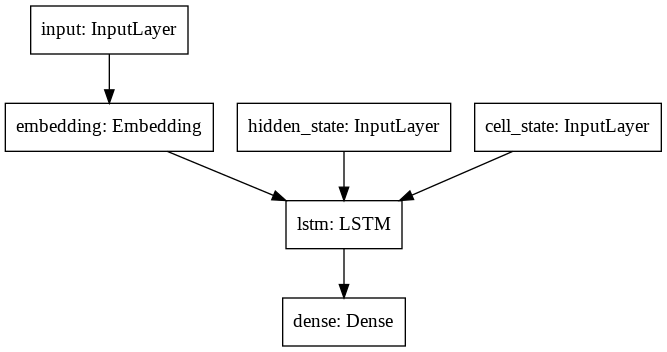

In [ ]:
decoder.model().summary()
tf.keras.utils.plot_model(decoder.model())

## 6. Making a custom training loop

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tqdm.notebook import tqdm_notebook
import pandas as pd

cross_entropy = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam()

In [ ]:
def get_inputs_outputs(ger_batch):
    return (ger_batch[:, :-1], ger_batch[:, 1:])

In [ ]:
@tf.function
def get_loss_and_grads(encoder, decoder, eng_inp, ger_inp, ger_out):
    with tf.GradientTape() as tape:
        h, c = encoder(eng_inp)
        ger_pred, _, _ = decoder(ger_inp, h, c)
        loss = cross_entropy(ger_out, ger_pred)
        grads_enc, grads_dec = tape.gradient(loss,
                                             [encoder.trainable_variables,
                                              decoder.trainable_variables])
        
    return (loss, grads_enc, grads_dec)

In [ ]:
def train_enc_dec(encoder, decoder, train_data, val_data, epochs, val_steps=100):

    training_loss = []
    validation_loss = []

    for epoch in tqdm_notebook(range(epochs)):
        train_loss_mean = Mean()
        val_loss_mean = Mean()

        for eng_batch, ger_batch in train_data:
            ger_inp, ger_out = get_inputs_outputs(ger_batch)
            loss, grads_enc, grads_dec = get_loss_and_grads(encoder, decoder,
                                                            eng_batch, ger_inp,
                                                            ger_out)
            optimizer.apply_gradients(zip(grads_enc, 
                                          encoder.trainable_variables))
            optimizer.apply_gradients(zip(grads_dec, 
                                          decoder.trainable_variables))
            
            train_loss_mean(loss)

        for eng_batch, ger_batch in val_data.take(val_steps):
            ger_inp, ger_out = get_inputs_outputs(ger_batch)
            h, c = encoder(eng_batch)
            ger_pred, _, _ = decoder(ger_inp, h, c)
            loss = cross_entropy(ger_out, ger_pred)
            
            val_loss_mean(loss)

        curr_train_loss = train_loss_mean.result().numpy()
        curr_val_loss = val_loss_mean.result().numpy()

        training_loss.append(curr_train_loss)
        validation_loss.append(curr_val_loss)

        print('Epoch: {:02d}\tLoss: {:.3f}\tValidation Loss: {:.3f}'\
              .format(epoch+1, curr_train_loss, curr_val_loss))
    
    history = pd.DataFrame({'loss': training_loss,
                           'val_loss': validation_loss})

    return encoder, decoder, history

In [ ]:
tf.keras.backend.clear_session()

input_shape = temp_eng.shape[1:]
encoder = Encoder(input_shape)
decoder = Decoder()

encoder, decoder, history = train_enc_dec(encoder, decoder, train_data,
                                          test_data, epochs=10)

Epoch: 01	Loss: 5.308	Validation Loss: 4.574
Epoch: 02	Loss: 4.026	Validation Loss: 3.686
Epoch: 03	Loss: 3.104	Validation Loss: 2.942
Epoch: 04	Loss: 2.286	Validation Loss: 2.300
Epoch: 05	Loss: 1.577	Validation Loss: 1.764
Epoch: 06	Loss: 1.027	Validation Loss: 1.403
Epoch: 07	Loss: 0.670	Validation Loss: 1.210
Epoch: 08	Loss: 0.462	Validation Loss: 1.115
Epoch: 09	Loss: 0.337	Validation Loss: 1.079
Epoch: 10	Loss: 0.256	Validation Loss: 1.057



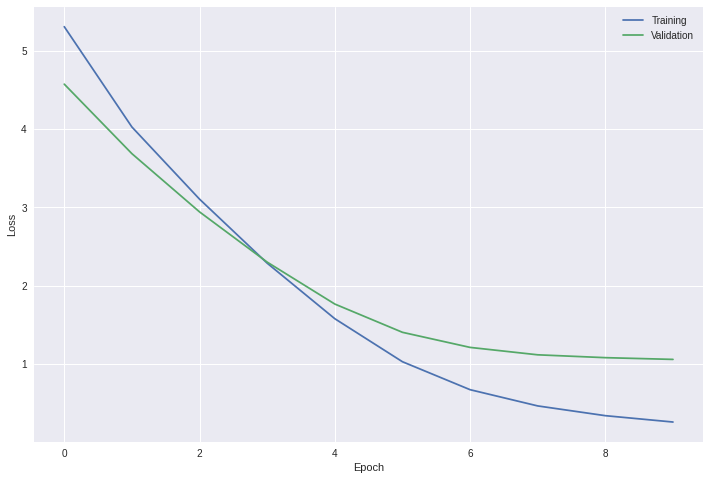

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=(12,8))
plt.plot(history['loss'], label='Training')
plt.plot(history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
encoder.save_weights('model/encoder.h5')
decoder.save_weights('model/decoder.h5')

In [ ]:
import json
with open('history.json', 'w') as f:
    json.dump(history.to_json(), f)

## 7. Using the model to translate

In [ ]:
random_index = np.random.choice(20000, 10)
eng_samples = []
translations = []
for i in random_index:
    eng = data_examples[i].split('\t')[0]
    ger = data_examples[i].split('\t')[1]
    eng_samples.append(eng)
    translations.append(ger)

In [ ]:
def get_encoder_input(sentence):
    processed = preprocess_sentence(sentence)
    return embedding_layer(tf.constant(processed.split()))[None]

In [ ]:
def translate(sentence, max_len=13):
    encoder_input = get_encoder_input(sentence)
    h, c = encoder(encoder_input)
    next_input = np.array(tokenizer.word_index['<start>'])[None, None]
    end_token = tokenizer.word_index['<end>']
    translation = []

    for _ in range(max_len):
        out, h, c = decoder(next_input, h, c)
        pred = np.argmax(out)
        if pred == end_token:
            break
        next_input = pred[None, None]
        translation.append(tokenizer.index_word[pred])

    return ' '.join(translation)

In [ ]:
for english, german in zip(eng_samples, translations):
    print('English:', english)
    print('Actual German:', german)
    print('Translated German:', translate(english))
    print()

English: My father is in.
Actual German: Mein Vater ist zuhause.
Translated German: mein vater ist hier .

English: He kissed her.
Actual German: Er küsste sie.
Translated German: er kuesste sie .

English: Tom loves us.
Actual German: Tom liebt uns.
Translated German: tom liebt uns .

English: I saw the message.
Actual German: Ich habe die Nachricht gesehen.
Translated German: ich habe euren vater gesehen .

English: Please wait.
Actual German: Bitte warten Sie.
Translated German: enspann dich bitte .

English: Have you showered?
Actual German: Hast du geduscht?
Translated German: hast du unterschrieben ?

English: I have a good job.
Actual German: Ich habe einen guten Arbeitsplatz.
Translated German: ich habe eine idee .

English: What's the score?
Actual German: Wie steht es?
Translated German: welcher ist es ?

English: Tom liked you.
Actual German: Tom mochte dich.
Translated German: tom mochte sie .

English: He's paraplegic.
Actual German: Er ist querschnittsgelähmt.
Translated 